In [40]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import salem
import seaborn as sns
import statsmodels.api as sm
import swiss_uhi_utils as suhi
import xarray as xr
from rasterio import transform

from lausanne_greening_scenarios import utils

In [2]:
metrics = ['proportion_of_landscape', 'area_mn', 'shape_index_am', 'edge_density']

In [35]:
biophysical_table_filepath = '../data/processed/biophysical-table.csv'
lulc_raster_filepath = '../data/processed/agglom-lulc.tif'
t_da_filepath = '../data/processed/lst-da.nc'
# t_da_filepath = '../data/processed/tair-ucm.nc'

In [4]:
ls, ls_meta = utils.get_reclassif_landscape(
    lulc_raster_filepath, biophysical_table_filepath)

In [36]:
lulc_da = salem.open_xr_dataset(lulc_raster_filepath)['data']
t_da = suhi.align_ds(xr.open_dataarray(t_da_filepath), lulc_da)
hottest_day_da = t_da.isel(time=t_da.groupby('time').max(dim=['x', 'y']).argmax())
t_arr = hottest_day_da.values

In [6]:
zone_pixel_width = 60
zone_pixel_height = 60
zga = utils.get_zonal_grid_analysis(ls, ls_meta, zone_pixel_width=zone_pixel_width, zone_pixel_height=zone_pixel_height)

In [7]:
metrics_df = zga.compute_class_metrics_df(metrics=metrics).apply(pd.to_numeric)

In [8]:
crs = zga.landscape_meta['crs']
p_center = gpd.GeoSeries([utils.BASE_MASK], crs=utils.BASE_MASK_CRS).to_crs(crs).iloc[0]

In [9]:
class_val = utils.TREE_CLASS

In [185]:
regr_df = metrics_df.iloc[metrics_df.index.get_level_values('class_val') == class_val].reset_index(drop=True)
regr_df['dist_center'] = gpd.GeoSeries(gpd.points_from_xy(*transform.xy(zga.landscape_meta['transform'], *np.array(zga.zones).transpose())), crs=crs).apply(lambda p: p_center.distance(p))
regr_df['T'] = np.nanmean(utils.get_zonal_grid_t_arrs(t_arr, zga), axis=(1, 2))

regr_df_nonna = ~regr_df.isna().any(axis=1)
regr_df = regr_df.dropna()

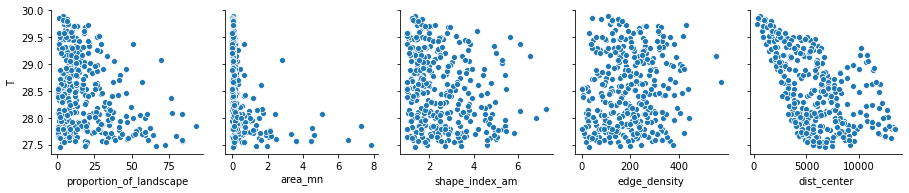

In [30]:
sns.pairplot(regr_df, x_vars=regr_df.columns.drop('T'), y_vars=['T'])

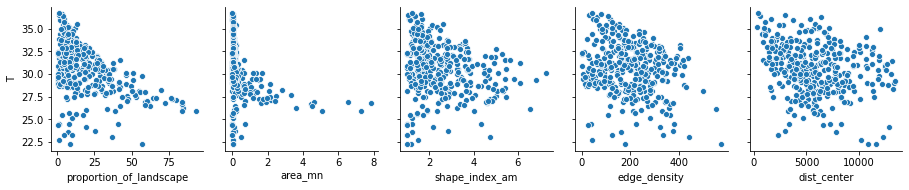

In [38]:
# with LST
# sns.pairplot(regr_df, x_vars=regr_df.columns.drop('T'), y_vars=['T'])

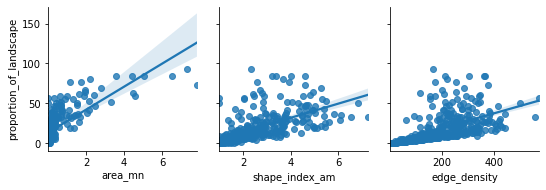

In [268]:
sns.pairplot(regr_df, x_vars=regr_df.columns.drop(['proportion_of_landscape', 'dist_center', 'T']), y_vars=['proportion_of_landscape'], kind='reg')

In [266]:
sm.OLS(regr_df['proportion_of_landscape'], sm.add_constant(regr_df.drop(['proportion_of_landscape', 'dist_center', 'T'], axis=1))).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     proportion_of_landscape   R-squared:                       0.763
Model:                                 OLS   Adj. R-squared:                  0.761
Method:                      Least Squares   F-statistic:                     381.2
Date:                     Thu, 06 Aug 2020   Prob (F-statistic):          1.27e-110
Time:                             16:19:18   Log-Likelihood:                -1293.8
No. Observations:                      359   AIC:                             2596.
Df Residuals:                          355   BIC:                             2611.
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.8386      1.157     -4.183      0.000      -7.113      -2.564
area_mn           11.8290      0.549     21.548      0.000      10.749      12.909
shape_index_am     2.8688      0.465      6.176      0.000       1.955       3.782
edge_density       0.0600      0.005     11.899      0.000       0.050       0.070
==============================================================================
Omnibus:                      141.393   Durbin-Watson:                   1.461
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1102.064
Skew:                           1.441   Prob(JB):                    4.90e-240
Kurtosis:                      11.085   Cond. No.                         563.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

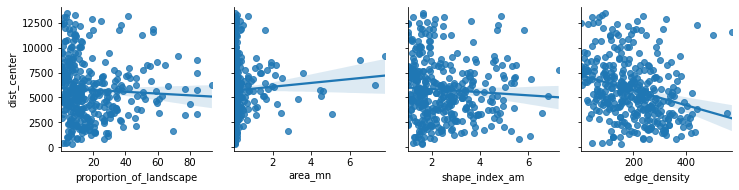

In [ ]:
sns.pairplot(regr_df, x_vars=regr_df.columns.drop(['dist_center', 'T']), y_vars=['dist_center'], kind='reg')

In [282]:
sm.OLS(regr_df['dist_center'], sm.add_constant(regr_df.drop(['dist_center', 'T'], axis=1))).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            dist_center   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     8.644
Date:                Thu, 06 Aug 2020   Prob (F-statistic):           1.15e-06
Time:                        16:32:47   Log-Likelihood:                -3366.0
No. Observations:                 359   AIC:                             6742.
Df Residuals:                     354   BIC:                             6761.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    7088.7063    381.204     18.596      0.000    6338.996    7838.417
proportion_of_landscape    12.9816     17.075      0.760      0.448     -20.600      46.563
area_mn                   126.2692    268.311      0.471      0.638    -401.416     653.954
shape_index_am             95.1027    157.276      0.605      0.546    -214.210     404.415
edge_density               -9.5030      1.920     -4.950      0.000     -13.279      -5.728
==============================================================================
Omnibus:                       27.134   Durbin-Watson:                   0.354
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.068
Skew:                           0.699   Prob(JB):                     1.79e-07
Kurtosis:                       3.347   Cond. No.                         580.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [274]:
from sklearn import linear_model
from sklearn import feature_selection

In [283]:
results = sm.OLS(regr_df['T'], sm.add_constant(regr_df.drop(['T'], axis=1))).fit()

In [285]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      T   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     33.33
Date:                Thu, 06 Aug 2020   Prob (F-statistic):           7.52e-28
Time:                        16:33:07   Log-Likelihood:                -806.86
No. Observations:                 359   AIC:                             1626.
Df Residuals:                     353   BIC:                             1649.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      33.4321      0.430     77.680      0.000      32.586      34.279
proportion_of_landscape    -0.0817      0.014     -5.951      0.000      -0.109      -0.055
area_mn                     0.0519      0.216      0.241      0.810      -0.372       0.476
shape_index_am              0.2607      0.126      2.063      0.040       0.012       0.509
edge_density               -0.0017      0.002     -1.052      0.294      -0.005       0.001
dist_center                -0.0003   4.27e-05     -6.846      0.000      -0.000      -0.000
==============================================================================
Omnibus:                       61.497   Durbin-Watson:                   0.693
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.947
Skew:                          -0.965   Prob(JB):                     1.33e-24
Kurtosis:                       4.904   Cond. No.                     2.31e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# (regr_df.drop('T', axis=1) ** 2).rename(columns=lambda col: col + '^2')

In [ ]:
linear_model.LinearRegression().fit(regr_df.drop('T', axis=1), regr_df['T'])

In [ ]:
feature_selection.RFE()

In [ ]:
from pysal.lib import weights
from pysal.model import spreg

In [188]:
threshold = 2
w = weights.DistanceBand.from_array(np.array(zga.zones)[regr_df_nonna], threshold)

In [250]:
y_col = 'T'
X = regr_df.drop(y_col, axis=1)
m = spreg.ML_Error(regr_df[y_col].values[:, None], X.values, w=w, name_y=y_col, name_x=list(X.columns))
m_df = pd.DataFrame({'coeff': m.betas[:, 0], 'p': np.array(m.z_stat)[:, 1]}, index=m.name_x)

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/scipy/optimize/_minimize.py:778: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


In [247]:
print(m.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :           T                Number of Observations:         359
Mean dependent var  :     30.5838                Number of Variables   :           6
S.D. dependent var  :      2.7825                Degrees of Freedom    :         353
Pseudo R-squared    :      0.0021
Sigma-square ML     :       2.387                Log likelihood        :    -693.296
S.E of regression   :       1.545                Akaike info criterion :    1398.592
                                                 Schwarz criterion     :    1421.892

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [305]:
log_regr_df = regr_df.apply(np.log)

In [311]:
y_col = 'T'
X = regr_df.drop(y_col, axis=1)
log_m = spreg.ML_Error(log_regr_df[y_col].values[:, None], X.values, w=w, name_y=y_col, name_x=list(X.columns))

In [312]:
spreg.diagnostics.breusch_pagan(log_m)

{'df': 5, 'bp': 45.22575646464974, 'pvalue': 1.3053503654337833e-08}

In [302]:
spreg.diagnostics.breusch_pagan(m)

{'df': 5, 'bp': 47.15179311994215, 'pvalue': 5.29068873985386e-09}

(array([ 2.,  5.,  4., 16., 43., 79., 78., 62., 56., 14.]),
 array([-0.20961121, -0.1466909 , -0.08377059, -0.02085027,  0.04207004,
         0.10499035,  0.16791067,  0.23083098,  0.29375129,  0.35667161,
         0.41959192]),
 <BarContainer object of 10 artists>)

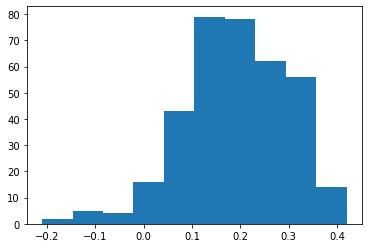

In [313]:
plt.hist(log_m.y - log_m.predy)

(array([ 2.,  6.,  5., 26., 64., 79., 63., 63., 39., 12.]),
 array([-5.33499441, -3.5225755 , -1.7101566 ,  0.1022623 ,  1.9146812 ,
         3.72710011,  5.53951901,  7.35193791,  9.16435681, 10.97677572,
        12.78919462]),
 <BarContainer object of 10 artists>)

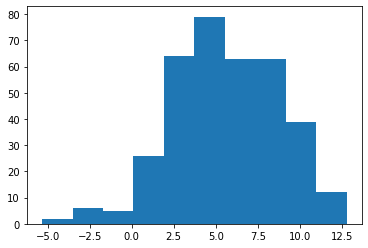

In [297]:
plt.hist(m.y - m.predy)

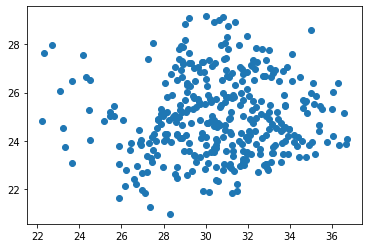

In [296]:
plt.scatter(m.y, m.predy)

In [256]:
def get_spreg_ml_error_model(regr_df, y_col, w):
    X = regr_df.drop(y_col, axis=1)
    return spreg.ML_Error(regr_df[y_col].values[:, None],
                          X.values,
                          w=w,
                          name_y=y_col,
                          name_x=list(X.columns))

def get_partial_spreg_model(regr_df, y_col, x_col, covar, w):
    # Based on https://gist.github.com/fabianp/9396204419c7b638d38f
    # 1. perform a regression with `x_col` as target and `covar` as features

    m_x = get_spreg_ml_error_model(regr_df[covar], x_col, w)
    # 2. perform a regression with `y_col` as target and `covar` as features
    m_y = get_spreg_ml_error_model(regr_df[covar], y_col, w)
    # 3. return the correlation coefficient between the residuals of both
    # regressions
    return stats.pearsonr(m_x.y - m_x.predy, m_y.y - m_y.predy)

In [259]:
x_col = 'proportion_of_landscape'
y_col = 'T'
ret = get_partial_spreg_model(regr_df, y_col, x_col, covar, w)

KeyError: "['proportion_of_landscape'] not found in axis"

In [248]:
m.std_err

array([1.07802182e+00, 1.01900138e-02, 1.42784590e-01, 9.07987863e-02,
       1.21693336e-03, 1.27023257e-04, 8.70574100e-04])

In [233]:
m_df

,coeff,p
CONSTANT,24.158418,3.147725e-111
proportion_of_landscape,-0.044076,1.522370e-05
area_mn,0.147621,3.011970e-01
shape_index_am,-0.093366,3.038225e-01
edge_density,-0.002525,3.796333e-02
dist_center,0.000408,1.333669e-03
lambda,0.086070,0.000000e+00


In [80]:
x = 'proportion_of_landscape'
y = 'T'
covar = covars

col = pg.utils._flatten_list([x, y, covar])
data = regr_df[col].dropna()

In [78]:
C = (data[col] - data[col].mean(axis=0)) / data[col].std(axis=0)

In [81]:
cvar = np.atleast_2d(C[covar].to_numpy())

In [88]:
beta_x = np.linalg.lstsq(cvar, C[x].to_numpy(), rcond=None)[0]
beta_y = np.linalg.lstsq(cvar, C[y].to_numpy(), rcond=None)[0]

res_x = C[x].to_numpy() - cvar @ beta_x
res_y = C[y].to_numpy() - cvar @ beta_y

In [244]:
covars

['area_mn', 'shape_index_am', 'edge_density', 'dist_center']

In [66]:
covars = pd.Series(metrics + ['dist_center'])
covars = list(covars[covars != 'proportion_of_landscape'])
corr_df = pd.DataFrame(index=['r', 'p'], columns=metrics[1:])
for feature in covars:
    corr_df[feature] = pg.partial_corr(data=regr_df, y='T', x=feature, covar='proportion_of_landscape')[['r', 'p-val']].values.flatten()
corr_df['proportion_of_landscape'] = pg.partial_corr(data=regr_df, y='T', x='proportion_of_landscape', covar=covars)[['r', 'p-val']].values.flatten()

In [73]:
pg.partial_corr(data=regr_df, y='T', x='proportion_of_landscape', covar=covars)

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,359,-0.301963,"[-0.39, -0.2]",0.091181,0.086076,5.274881e-09,1.552e+06,0.999957


In [67]:
corr_df

,area_mn,shape_index_am,edge_density,dist_center,proportion_of_landscape
r,-0.024502,0.103961,0.061856,-3.403871e-01,-3.019625e-01
p,0.643588,0.049040,0.242392,3.453425e-11,5.274881e-09
